# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 7: Diffusion and Poisson equation in one and more dimensions
### 7.1. Solution of previous homework with multigrid method

### 1)+ 2) Constrcut 2D matrices P and R

Restrict Matrix R:
 [[0.75 0.25 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5  0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.25 0.5  0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.25 0.75]]
Restriction of linear array:
 [0.25 2.   4.   6.   7.75]
Prolongate Matrix P:
 [[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.

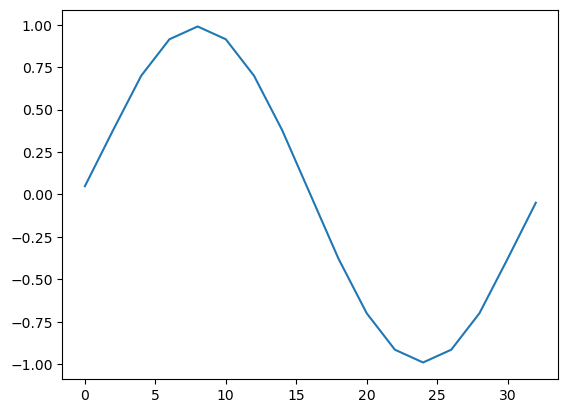

In [247]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import bicgstab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags, kron, eye


def prolongate(n):
    """Get prolongation matrix with weighting ]1/2 1 1/2[

    Args:
        n (int): current grid size

    Returns:
        np.array: prolongation matrix of form (n*2-1) x n
    """
    insert_matrix = np.eye(n)
    prolongate_matrix = np.zeros((n*2-1,n))
    prolongate_matrix[::2,:] = insert_matrix
    idx = np.diag_indices(*prolongate_matrix[1::2,:].shape)
    prolongate_matrix[1::2,:][np.array(idx),np.array(idx)] = 0.5
    idx = np.diag_indices(*prolongate_matrix[1::2,:].shape)
    prolongate_matrix[1::2,:][np.array(idx),np.array(idx)+1] = 0.5
    return prolongate_matrix

def restrict(n):
    """Get restriction matrix with weighting [1/4 1/2 1/4]

    Args:
        n (int): Current grid size

    Returns:
        np.array: Restriction matrix of form (n/2+1) x n
    """
    # Construct restrict matrix as transpose of prolongate
    restrict_matrix = prolongate(n//2+1).T
    # Border cases for dirichlet boundary conditions
    restrict_matrix[0,0] = 1.5
    restrict_matrix[-1,-1] = 1.5
    return restrict_matrix*0.5

h = 9

# Test on small grid
test_function = np.arange(0,h)
print("Restrict Matrix R:\n", restrict(h))
print("Restriction of linear array:\n", restrict(h)@test_function)
print("Prolongate Matrix P:\n", prolongate(h))
print("Prolongation of linear array:\n", prolongate(h//2+1)@restrict(h)@test_function)

# Test on non-linear function
h = 2**5+1
plt.plot(prolongate(h//2+1)@restrict(h)@np.sin(np.linspace(0,2*np.pi,h)))

### 3) Take $9\times 9$ laplacian matrix and restrict it with $P$ and $R$

In [248]:
def get_laplacian(h):
    """Get Dense representation of the discrete laplacian operator 

    Args:
        h (int): Number of grid points

    Returns:
        np.array: Dense Laplace Operator
    """
    mat = np.ones(h)

    # Create Laplacian by using diagonal and off diagonal entries
    mat_dense = np.diag(-2*mat) + np.diag(mat[1:], -1) + np.diag(mat[1:], 1)

    # Dirichlet Boundary Conditions
    mat_dense[0,0] = 1
    mat_dense[-1,-1] = 1
    mat_dense[0,1] = 0
    mat_dense[-1,-2] = 0
    return mat_dense

# Check if restricted laplacian makes sense on small grid
h = 9
laplace_dense = get_laplacian(h)
print("Full Laplacian Matrix:\n",laplace_dense)
print("Restricted Laplacian Matrix:\n",restrict(h).dot(laplace_dense).dot(prolongate(h//2+1)))


Full Laplacian Matrix:
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Restricted Laplacian Matrix:
 [[ 0.75  0.    0.    0.    0.  ]
 [ 0.25 -0.5   0.25  0.    0.  ]
 [ 0.    0.25 -0.5   0.25  0.  ]
 [ 0.    0.    0.25 -0.5   0.25]
 [ 0.    0.    0.    0.    0.75]]


Makes sense (i guess lol)

### 4) Construct recursive function that applies V-Shaped Multigird using Jacobi Iteration

In [249]:
def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""

    # Create initial guess if needed
    if x is None:
        x = np.zeros(A[0].shape)

    # Create vector of the diagonal elements and substract them from A
    D = np.diag(A)
    R = A - np.diagflat(D)

    # Iterate for N times
    for i in range(N):
        x = (b - np.dot(R,x)) / D

    return x

def solve_multigrid(A,b,N=5,x=None):
    """Solves the equation Ax=b via the Multigrid method with a V-Cycle"""

    # Get current size
    h = b.shape[0]
    
    # Step 1: Relaxation step
    x = jacobi(A,b,N=N,x=x)

    # Terminate if grid is too small
    if h != 2:
        # Step 2: Compute residual
        residual = b - A@x

        # Step 3: Restrict residual to coarser mesh
        residual_restriced = restrict(h)@residual

        # Step 4: Solve Ae=r on coarsened mesh recursively
        A_restriced = restrict(h) @ A @ prolongate(h//2+1)
        error = solve_multigrid(A_restriced, residual_restriced, N, np.zeros(h//2+1))

        # Step 5: Prolong error to finer mesh and correct current solution
        error_prolonged = prolongate(h//2+1)@error
        x = x + error_prolonged

    # Step 6: Carry out further relaxation
    x = jacobi(A,b,N=N, x=x)
    return x


### 5) Compare Solution to Previous Exercise

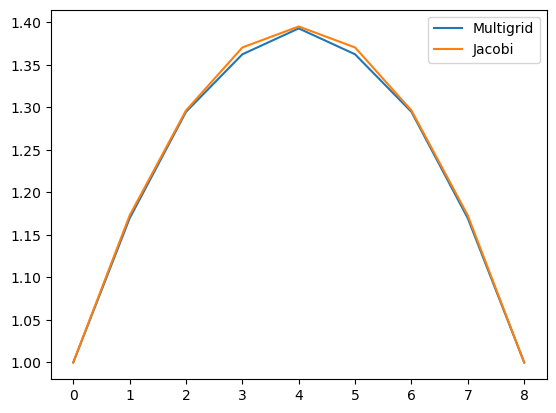

In [250]:

L  = 2
n  = 9 # Grid points
h  = L/n # Cell width
D  = 1

epsilon = np.ones(n)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

# Get laplacian matrix to solve Diffusion 
laplace_dense = get_laplacian(n)

solution_multigrid = solve_multigrid(laplace_dense, epsilon, N=10, x=np.ones(epsilon.shape))

solution_jacobi = jacobi(laplace_dense, epsilon, N=100, x=np.ones(epsilon.shape))

plt.plot(solution_multigrid, label="Multigrid")
plt.plot(solution_jacobi, label="Jacobi")
plt.legend()

As one can see, the multigrid method is able to solve the diffusion equation much faster than the plain Jacobi iteration. However, on such a small grid the multigrid method has some approximation errors. These can be decreased by increasing the Jacobi steps while relaxing the solution.

### 6) Compare Time with $N=129$ grid points

In [251]:

L  = 2
n  = 129 # Grid points
h  = L/n # Cell width
D  = 1

epsilon = np.ones(n)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

# Get laplacian matrix to solve Diffusion 
laplace_dense = get_laplacian(n)

In [252]:
%timeit solution_multigrid = solve_multigrid(laplace_dense, epsilon, N=100, x=np.ones(epsilon.shape))

3.63 ms ± 50.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [253]:
%timeit solution_jacobi = jacobi(laplace_dense, epsilon, N=20000, x=np.ones(epsilon.shape))

148 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The time it takes for the multigrid method to achieve the same accuary is substantially smaller than with only Jacobi steps. For this example Multigrid is $\approx 40$ times as fast as jacobi. To see that Jacobi only reaches the same accuracy with $N=20000$ we can look at the solution for $N/2$. 

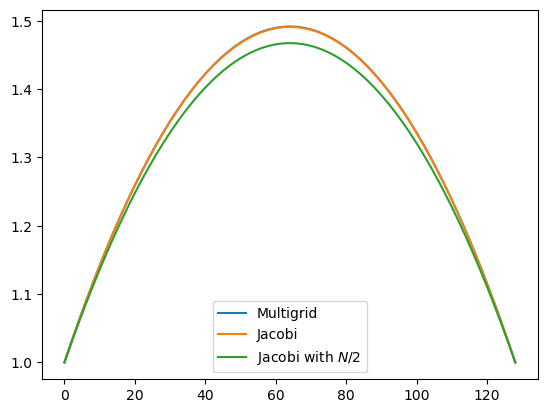

In [254]:
solution_multigrid = solve_multigrid(laplace_dense, epsilon, N=100, x=np.ones(epsilon.shape))
solution_jacobi = jacobi(laplace_dense, epsilon, N=20000, x=np.ones(epsilon.shape))
solution_jacobi_bad = jacobi(laplace_dense, epsilon, N=10000, x=np.ones(epsilon.shape)) 

plt.plot(solution_multigrid, label="Multigrid")
plt.plot(solution_jacobi, label="Jacobi")
plt.plot(solution_jacobi_bad, label="Jacobi with $N/2$")

plt.legend()

## 7.2 3D Poisson Equation Solver

In [255]:
def laplacian_matrix_3d(n, h):
    # 1D finite difference matrix for second derivative
    A = (1 / h**2) * diags([1, -2, 1], [-1, 0, 1], shape=(n, n), format='csr')

    # 3D Laplacian matrix using Kronecker products
    L = kron(kron(A, eye(n, format='csr')), eye(n, format='csr')) + \
        kron(kron(eye(n, format='csr'), A), eye(n, format='csr')) + \
        kron(kron(eye(n, format='csr'), eye(n, format='csr')), A)

    return L

laplacian_matrix = laplacian_matrix_3d(8,1)
print((laplacian_matrix).todense())

[[-6.  1.  0. ...  0.  0.  0.]
 [ 1. -6.  1. ...  0.  0.  0.]
 [ 0.  1. -6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -6.  1.  0.]
 [ 0.  0.  0. ...  1. -6.  1.]
 [ 0.  0.  0. ...  0.  1. -6.]]


In [256]:
# Parameters
n = 128  # Number of grid points along one dimension
L = 1.0  # Length of the domain
h = L / (n - 1)  # Grid spacing

# Set up the Poisson matrix A
A = laplacian_matrix_3d(n, h)

# Apply the boundary conditions
A[0, 0] = 1
A[-1, -1] = 1

# Set up the grid
x = np.linspace(0, L, n)
y = np.linspace(0, L, n)
z = np.linspace(0, L, n)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

# Set up the density with a 2x2 square in the middle
rho = np.zeros((n, n, n))
rho[(n//2)-1:n//2+1, (n//2)-1:n//2+1, (n//2)-1:n//2+1] = -1.0


# Flatten the density and solve the Poisson equation
rho_flat = rho.flatten()
phi_flat, info = bicgstab(A, rho_flat, tol=1e-6)

# Reshape the potential back to 3D
phi = phi_flat.reshape((n, n, n))

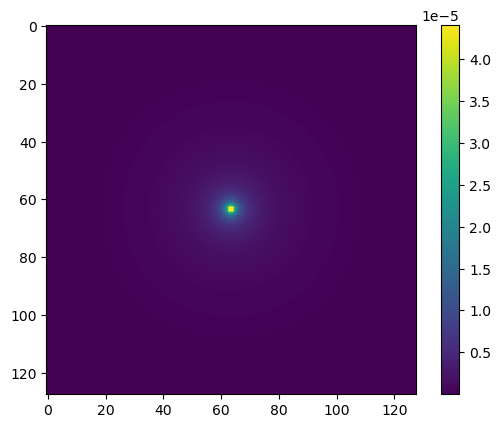

In [257]:
plt.imshow(phi[64])
plt.colorbar()

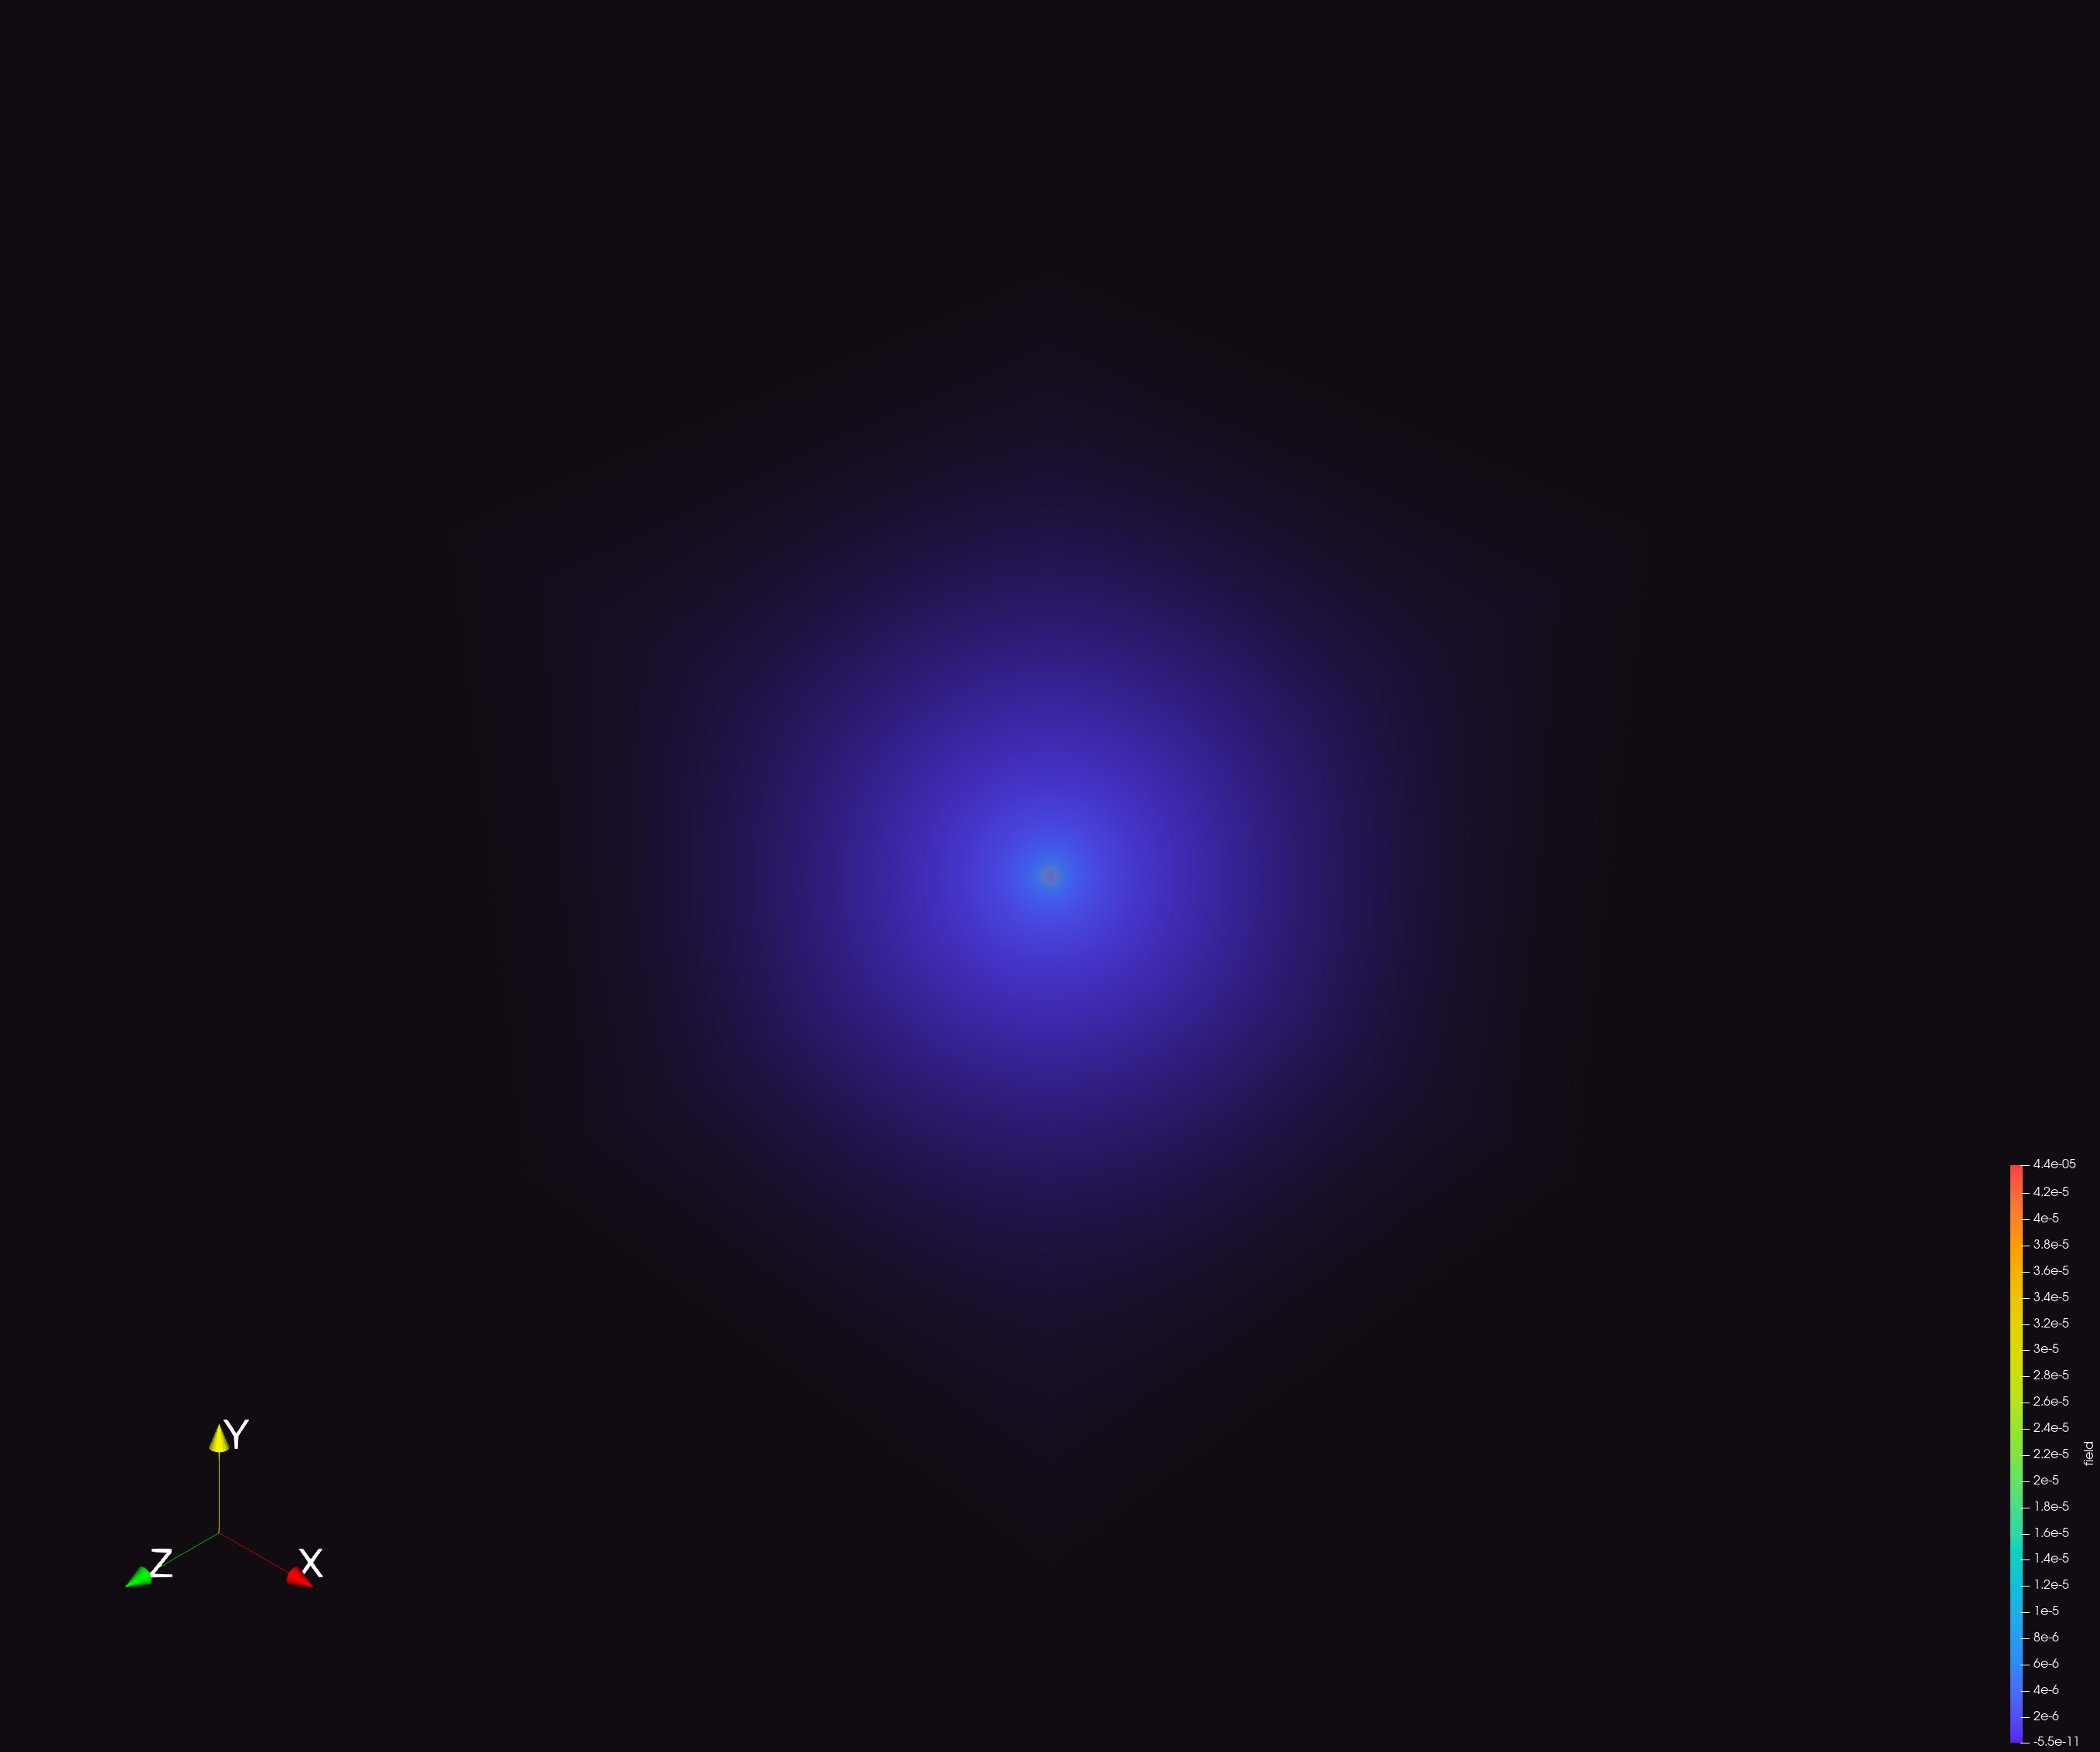

In [258]:
from IPython.display import Image
Image(filename="phi.png", width=600)

### For Fun: A Dipole

In [259]:
# Set up the density with two 2x2 square in the corners
rho = np.zeros((n, n, n))
rho[(n//2)-1:n//2+1, (n//2)-1:n//2+1, (n//4)-1:n//4+1] = 100.0
rho[(n//2)-1:n//2+1, (n//2)-1:n//2+1, (3*n//4)-1:3*n//4+1] = -100.0

# Flatten the density and solve the Poisson equation
rho_flat = rho.flatten()
phi_flat, info = bicgstab(A, rho_flat, tol=1e-6)

# Reshape the potential back to 3D
phi = phi_flat.reshape((n, n, n))

In [243]:
from maxpy.utils import save_as_vti
from findiff import Gradient

grad = Gradient(h=[x, y, z], acc=6)
du = grad(phi)
print(du.shape)

save_as_vti(du*100, None, savepath="./", name="EField")
save_as_vti(rho, None, savepath="./", name="rho")
save_as_vti(phi, None, savepath="./", name="phi")

(3, 128, 128, 128)


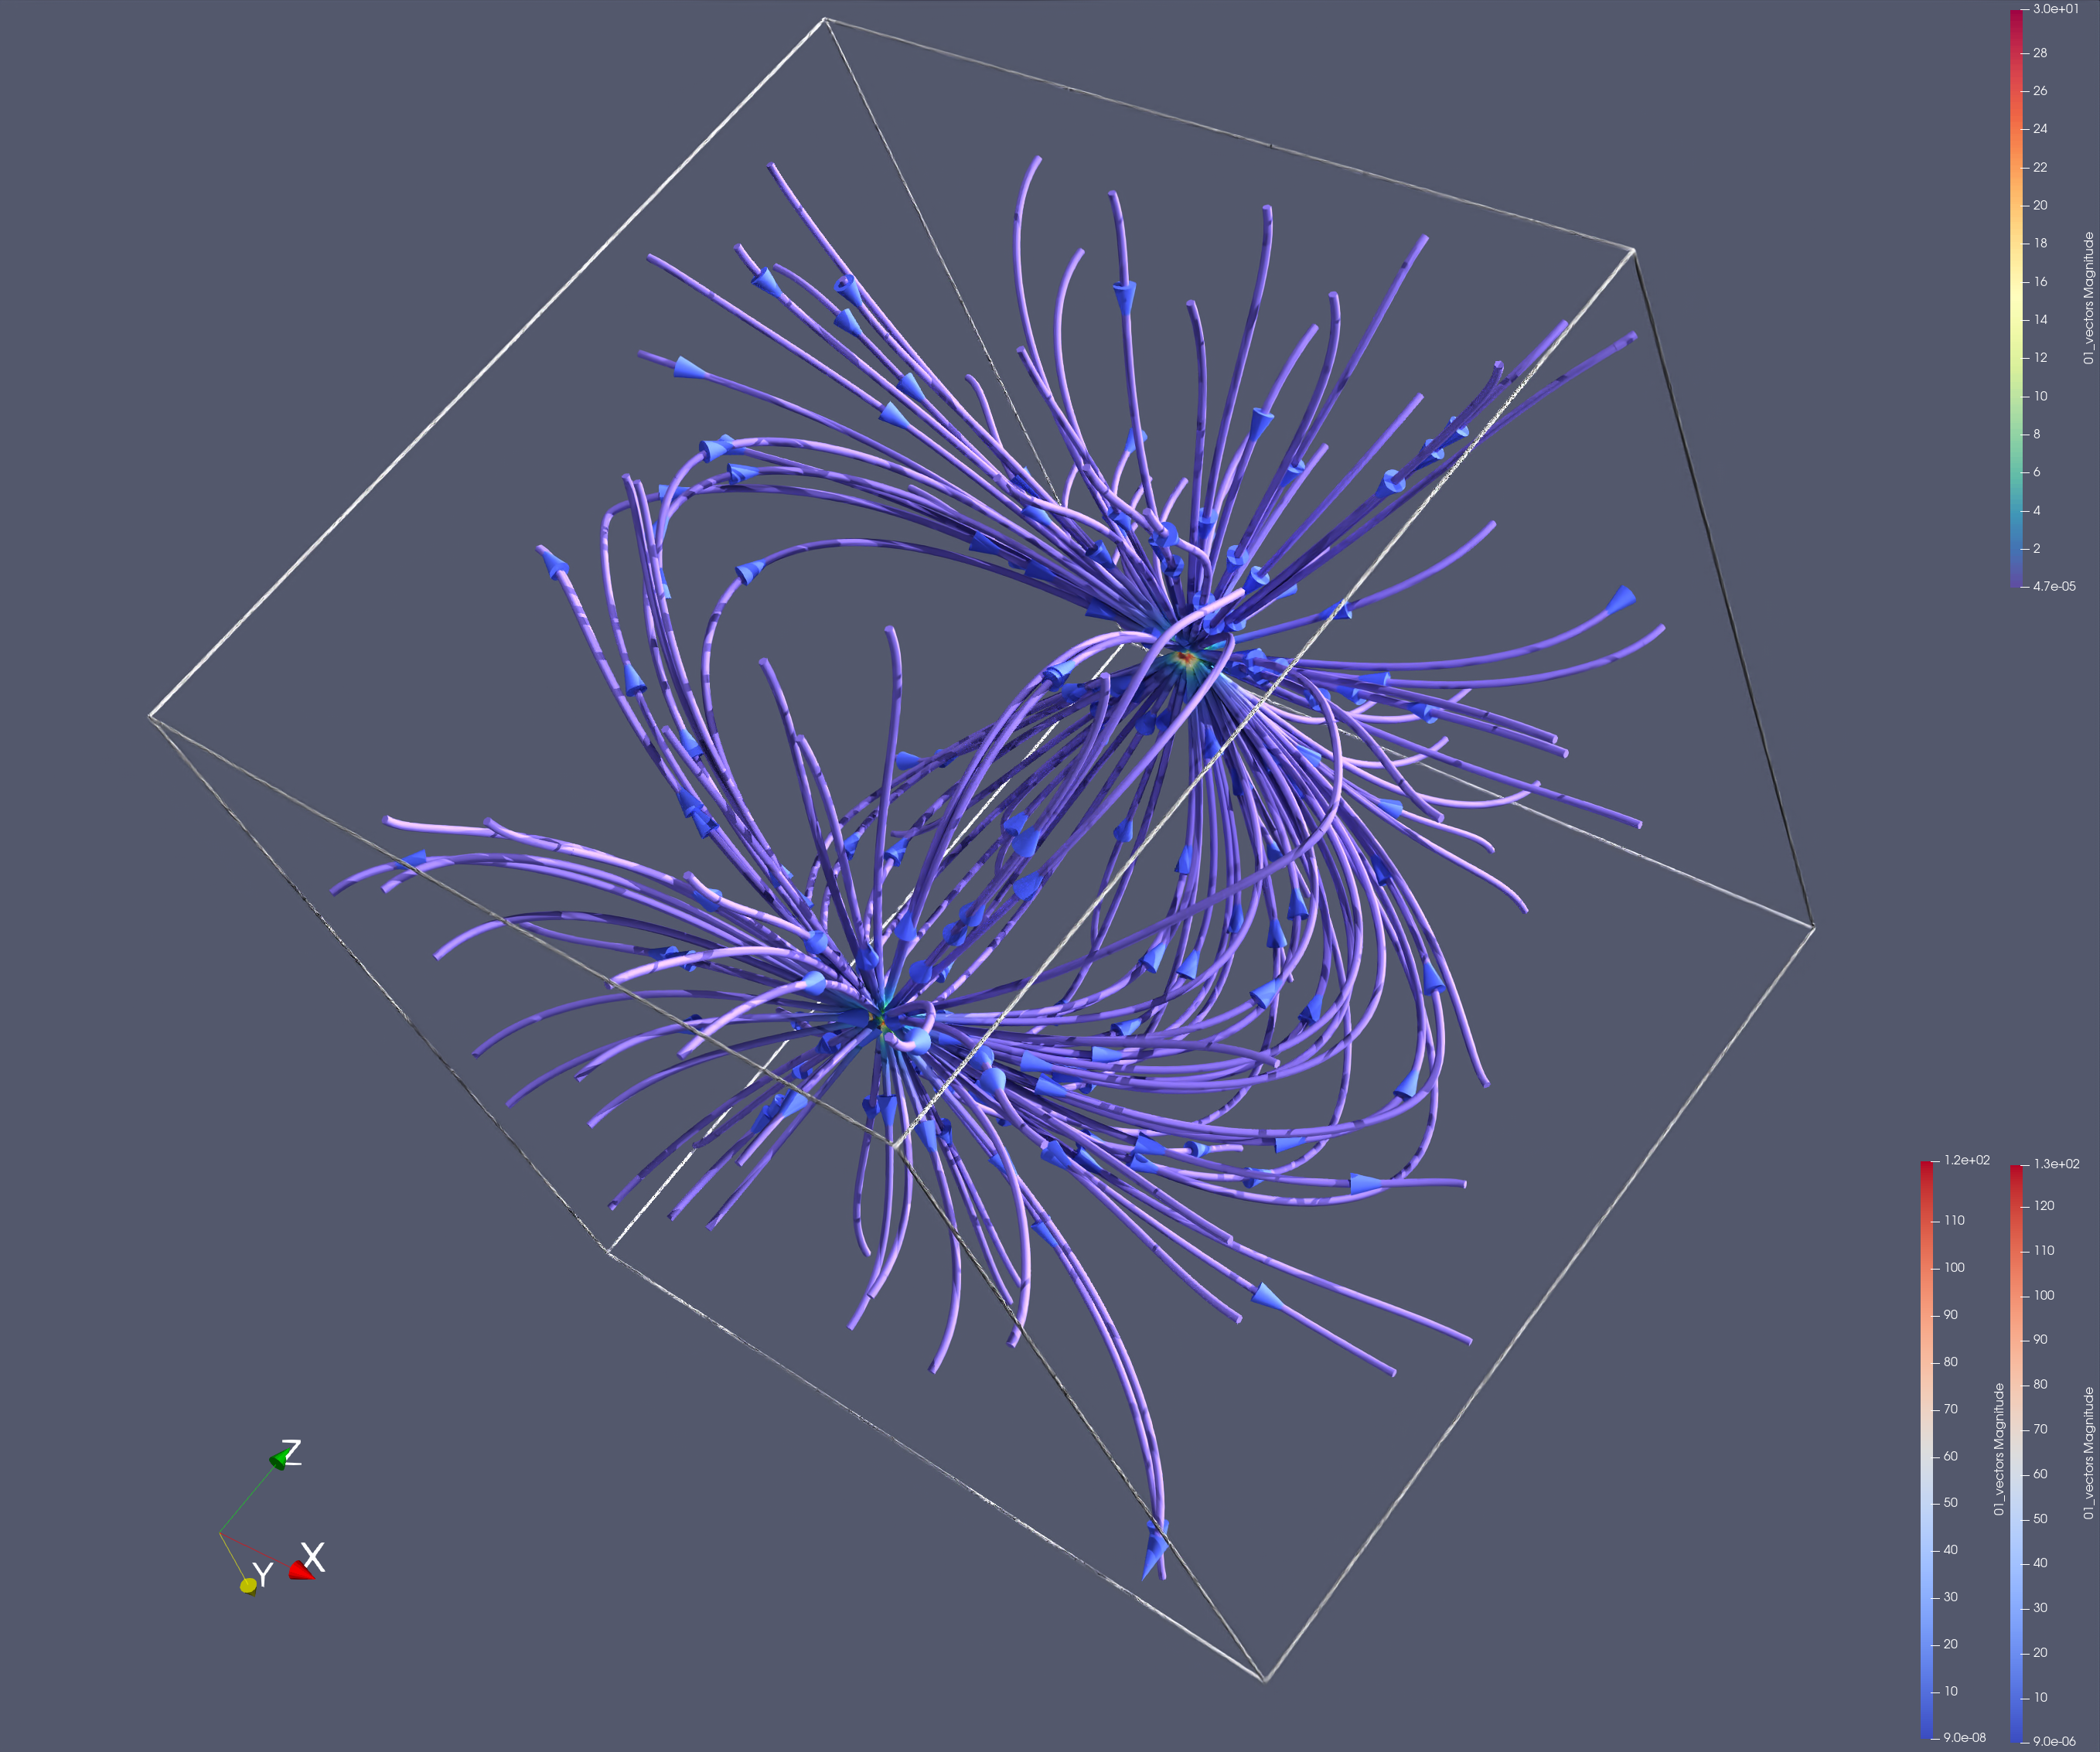

In [260]:
from IPython.display import Image
Image(filename="E_field.png", width=600)

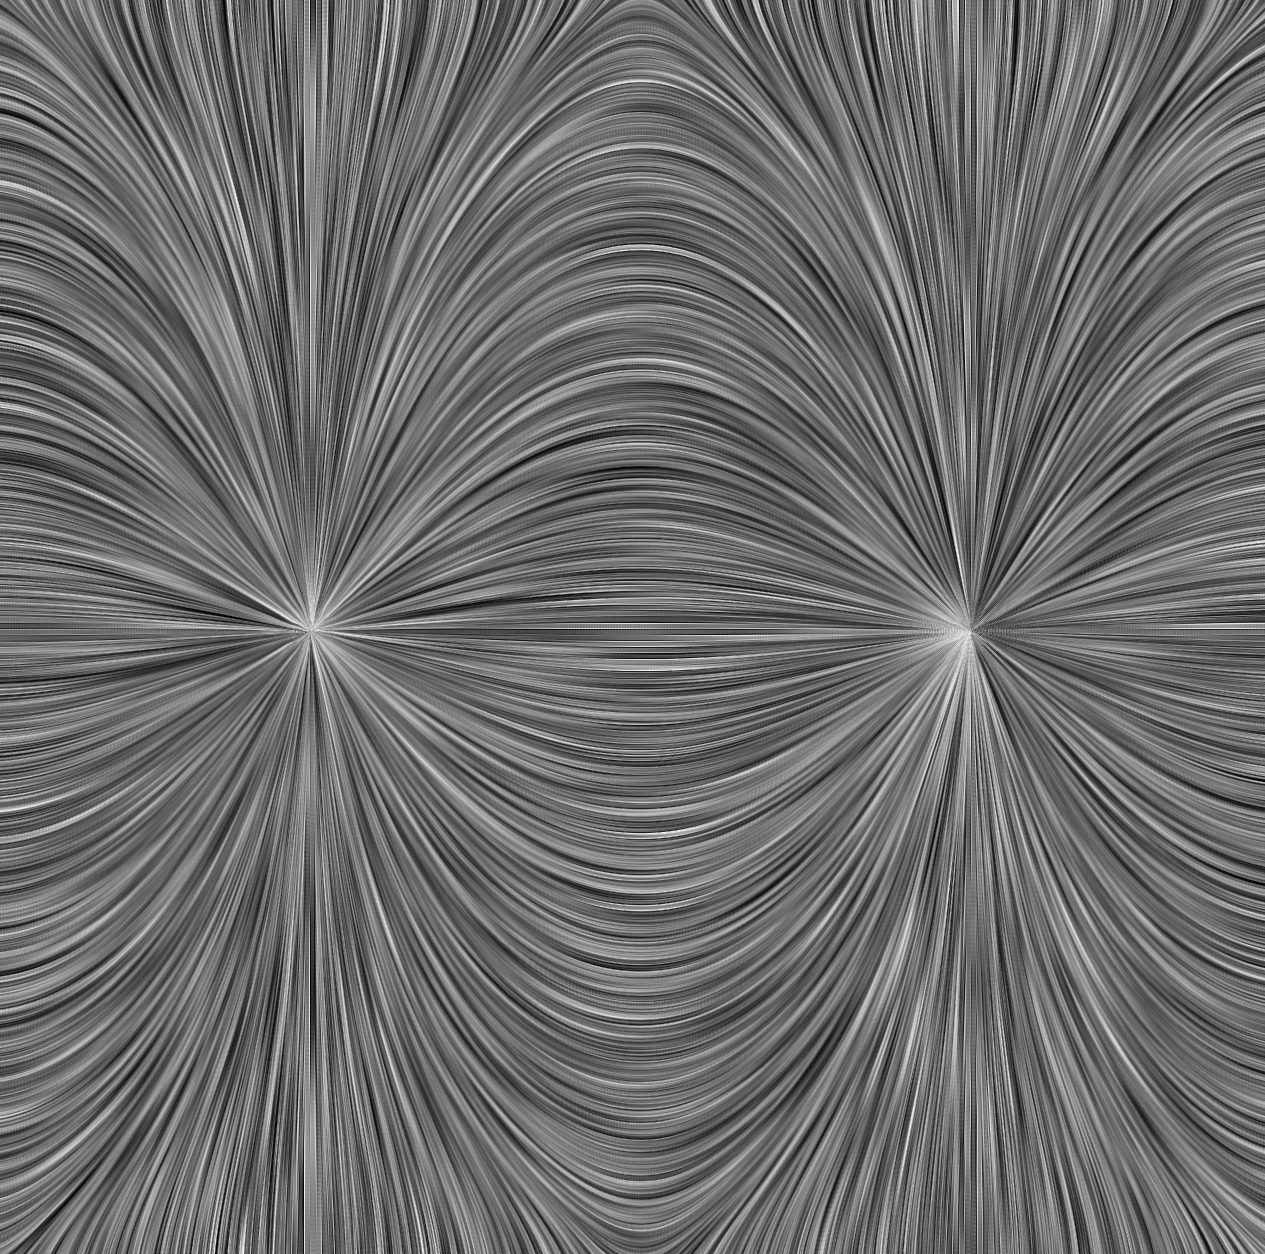

In [261]:
from IPython.display import Image
Image(filename="./Screenshot from 2023-12-05 16-29-16.png", width=600)